In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [2]:
path = 'dataset/data.csv'
df = pd.read_csv(path, encoding="ISO-8859-1")

# 1: Data Analysis

### 1.1 Dataset Overview

In [3]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### 1.2 Summary Statistics

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [6]:
df.describe(include='object')

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


# 2: Data Cleaning

## 2.1 Handling Missing Values

Determine on how to handle the missing value by indentifying how many missing value are there in each column

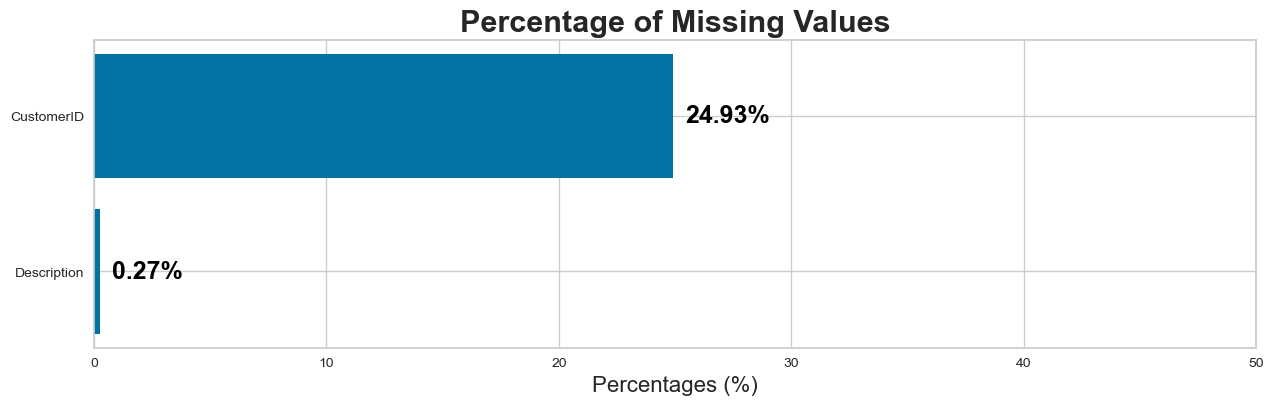

In [7]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage)

for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 50])

# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()


**conclusion :**


CustomerID is crucial for the making a customer segmentation. Therefore in this case imputing is not the best option because imputing might introduce noice on our data. Therefore the best option is to drop/delete the missing value

In [8]:
# extracting missing values in customerID and Description Columns
df[df['CustomerID'].isnull() | df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [9]:
# dropping the missing value in customerID and Description Columns
df = df.dropna(subset=['CustomerID', 'Description'])

## 2.2 Handling Duplicates
The presence of duplicates in our data might be data recording error rather than a genuine transactions. Keeping this data might introduce noise and potential accuracies for our reccomendation system

In [10]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [11]:
duplicate_rows = df[df.duplicated(keep=False)]
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])
duplicate_rows_sorted.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom


In [12]:
print(f"total of duplicated rows {df.duplicated().sum()} needed to be removed")

df.drop_duplicates(inplace=True)

print(f"total of duplicated rows {df.duplicated().sum()} needed to be removed")

total of duplicated rows 5225 needed to be removed
total of duplicated rows 0 needed to be removed


## 2.3 Treating Cancelled Transactions

To refine our understanding of customer behavior and preferences, we need to take into account the transactions that were cancelled. Initially, we will identify these transactions by filtering the rows where the InvoiceNo starts with "C". Subsequently, we will analyze these rows to understand their common characteristics or patterns:

In [13]:
df[~df['InvoiceNo'].apply(lambda x: str(x).isdigit())]

print(df[~df['InvoiceNo'].apply(lambda x: isinstance(x, int))].shape)

(401604, 8)


In [14]:
# Filters out rows with Invoice that start with C, which means canceled transaction. and create a new column indicating the transaction status
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

# filter out the transaction that are being cancelled 
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

,Quantity,UnitPrice
count,8872.000000,8872.000000
mean,-30.774910,18.899512
std,1172.249902,445.190864
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


**Conclusion from the Cancelled Transactions Data:**
- All quantities in the cancelled transactions are negative, indicating that these are indeed orders that were cancelled.
- The UnitPrice column has a considerable spread, showing that a variety of products, from low to high value, were part of the cancelled transactions.


**Strategy for Handling Cancelled Transactions:** 
Our objetive for this project is to create customer segmentation based on their purcasing behaviour and preferences and eventuallty we will create a reccomendation system. it's imperative to understand the cancellation patterns of customers. Therefore, the strategy is to retain these cancelled transactions in the dataset, marking them distinctly to facilitate further analysis. This approach will:

- Enhance the clustering process by incorporating patterns and trends observed in cancellation data, which might represent certain customer behaviors or preferences.
- Allow the recommendation system to possibly prevent suggesting products that have a high likelihood of being cancelled, thereby improving the quality of recommendations. 

In [15]:
cancelled_percentage = (cancelled_transactions.shape[0]/df.shape[0]) * 100

print(f"The percentage of cancelled transaction in our dataset is {cancelled_percentage:.2f}%")

The percentage of cancelled transaction in our dataset is 2.21%


## 2.4 Correcting StockCode Anomalies

find the number of unique stock codes and plot the top 10 most frequent stock along with their percentage frequency

In [16]:
# find the number of unique stockcide
unique_stock_code = df['StockCode'].nunique()
print(f"the total number of unique stock codes in the dataset : {unique_stock_code}")

the total number of unique stock codes in the dataset : 3684


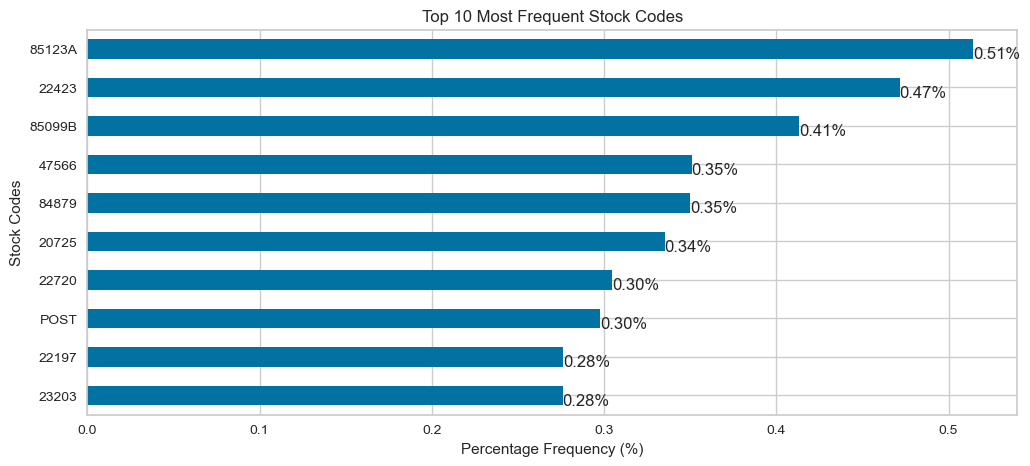

In [17]:
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100

plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh')

for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize='medium',)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()


**Conclusion on Stock Codes:**
- Product Variety: The dataset contains 3684 unique stock codes, indicating a substantial variety of products available in the online retail store. This diversity can potentially lead to the identification of distinct customer clusters, with preferences for different types of products.
- Popular Items: A closer look at the top 10 most frequent stock codes can offer insights into the popular products or categories that are frequently purchased by customers.
- Stock Code Anomalies: We observe that while most stock codes are composed of 5 or 6 characters, there are some anomalies like the code 'POST'. These anomalies might represent services or non-product transactions (perhaps postage fees) rather than actual products. To maintain the focus of the project, which is clustering based on product purchases and creating a recommendation system, these anomalies should be further investigated and possibly treated appropriately to ensure data integrity.

In [18]:
# Finding the number of numeric characters in each unique stock code
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

# Printing the value counts for unique stock codes
print("Value counts of numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    3676
0       7
1       1
Name: count, dtype: int64


**Conclusion:
The output indicates the following:**

- A majority of the unique stock codes (3676 out of 3684) contain exactly 5 numeric characters, which seems to be the standard format for representing product codes in this dataset.
- There are a few anomalies: 7 stock codes contain no numeric characters and 1 stock code contains only 1 numeric character. These are clearly deviating from the standard format and need further investigation to understand their nature and whether they represent valid product transactions.
Now, let's identify the stock codes that contain 0 or 1 numeric characters to further understand these anomalies:

In [19]:
# Finding and printing the stock codes with 0 and 1 numeric characters
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Printing each stock code on a new line
print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [20]:
# Calculating the percentage of records with these stock codes
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df)) * 100

# Printing the percentage
print(f"The percentage of records with anomalous stock codes in the dataset is: {percentage_anomalous:.2f}%")

The percentage of records with anomalous stock codes in the dataset is: 0.48%


**Inference:**

Based on the analysis, we find that a very small proportion of the records, 0.48%, have anomalous stock codes, which deviate from the typical format observed in the majority of the data. Also, these anomalous codes are just a fraction among all unique stock codes (only 8 out of 3684).

These codes seem to represent non-product transactions like "BANK CHARGES", "POST" (possibly postage fees), etc. Since they do not represent actual products and are a very small proportion of the dataset, including them in the analysis might introduce noise and distort the clustering and recommendation system.

**Strategy:**
Given the context of the project, where the aim is to cluster customers based on their product purchasing behaviors and develop a product recommendation system, it would be prudent to exclude these records with anomalous stock codes from the dataset. This way, the focus remains strictly on genuine product transactions, which would lead to a more accurate and meaningful analysis.

In [21]:
# Removing rows with anomalous stock codes from the dataset
print(f"before removing the anomalous stock code: {df.shape[0]}")
df = df[~df['StockCode'].isin(anomalous_stock_codes)]
print(f"After removing the anomalous stock code: {df.shape[0]}")

before removing the anomalous stock code: 401604
After removing the anomalous stock code: 399689


## 2.5 Cleaning the Description Column

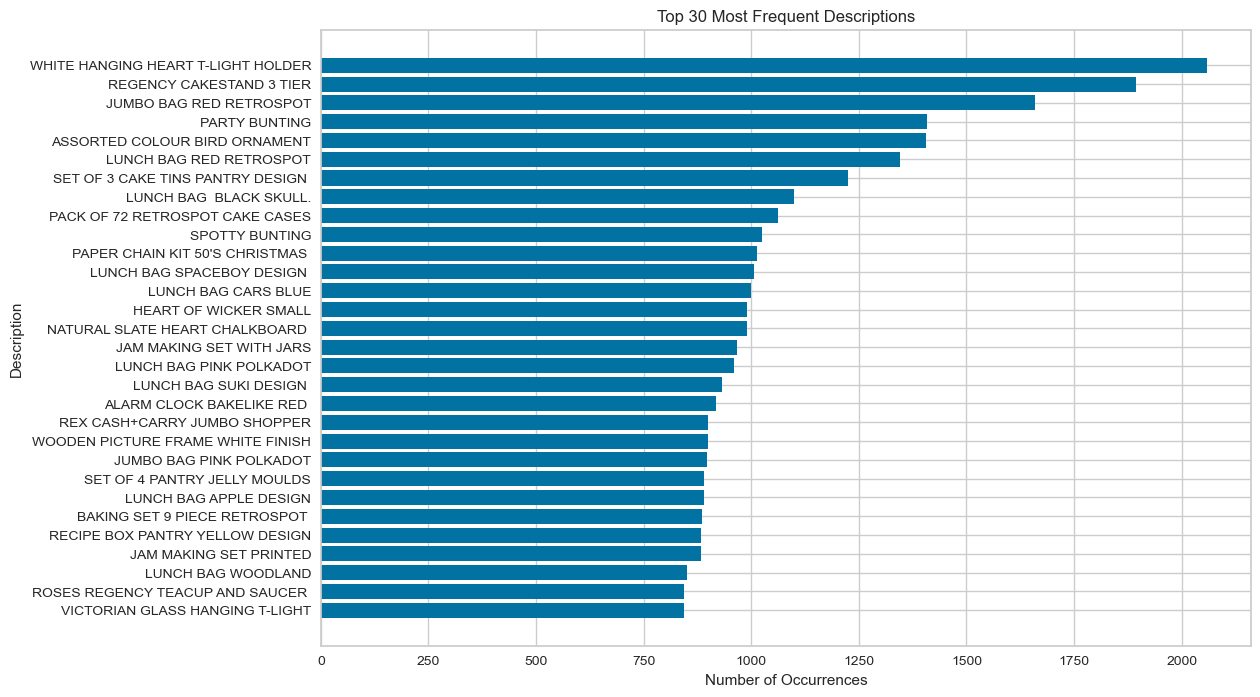

In [22]:
# Calculate the occurrence of each unique description and sort them
description_counts = df['Description'].value_counts()

# Get the top 30 descriptions
top_30_descriptions = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1])

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

**Inferences on Descriptions:**
- The most frequent descriptions are generally household items, particularly those associated with kitchenware, lunch bags, and decorative items.
- Interestingly, all the descriptions are in uppercase, which might be a standardized format for entering product descriptions in the database. However, considering the inconsistencies and anomalies encountered in the dataset so far, it would be prudent to check if there are descriptions entered in lowercase or a mix of case styles.

In [23]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Print the unique descriptions containing lowercase characters
print("The unique descriptions containing lowercase characters are:")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


**Conclusion:**
- Upon reviewing the descriptions that contain lowercase characters, it is evident that some entries are not product descriptions, such as "Next Day Carriage" and "High Resolution Image". These entries seem to be unrelated to the actual products and might represent other types of information or service details.

**Strategy:**
- Step 1: Remove the rows where the descriptions contain service-related information like "Next Day Carriage" and "High Resolution Image", as these do not represent actual products and would not contribute to the clustering and recommendation system we aim to build.
- Step 2: For the remaining descriptions with mixed case, standardize the text to uppercase to maintain uniformity across the dataset. This will also assist in reducing the chances of having duplicate entries with different case styles.

By implementing the above strategy, we can enhance the quality of our dataset, making it more suitable for the analysis and modeling phases of our project.

In [24]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

# Calculate the percentage of records with service-related descriptions
service_related_percentage = df[df['Description'].isin(service_related_descriptions)].shape[0] / df.shape[0] * 100

# Print the percentage of records with service-related descriptions
print(f"The percentage of records with service-related descriptions in the dataset is: {service_related_percentage:.2f}%")

# Remove rows with service-related information in the description
df = df[~df['Description'].isin(service_related_descriptions)]

# Standardize the text to uppercase to maintain uniformity across the dataset
df['Description'] = df['Description'].str.upper()

The percentage of records with service-related descriptions in the dataset is: 0.02%


## 2.6 Treating Zero Unit Price

In [25]:
df['UnitPrice'].describe()

count    399606.000000
mean          2.904957
std           4.448796
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

**Inference:**

The minimum unit price value is zero. This suggests that there are some transactions where the unit price is zero, potentially indicating a free item or a data entry error. To understand their nature, it is essential to investigate these zero unit price transactions further. A detailed analysis of the product descriptions associated with zero unit prices will be conducted to determine if they adhere to a specific pattern:

In [26]:
df[df['UnitPrice']==0].describe()

,Quantity,UnitPrice,CustomerID
count,33.000000,33.0,33.000000
mean,420.515152,0.0,14252.575758
std,2176.713608,0.0,1659.811925
min,1.000000,0.0,12415.000000
25%,2.000000,0.0,13081.000000
50%,11.000000,0.0,13985.000000
75%,36.000000,0.0,14911.000000
max,12540.000000,0.0,18059.000000


In [27]:
df[df['UnitPrice']==0].describe()['Quantity']

count       33.000000
mean       420.515152
std       2176.713608
min          1.000000
25%          2.000000
50%         11.000000
75%         36.000000
max      12540.000000
Name: Quantity, dtype: float64

**Inferences on UnitPrice:**
- The transactions with a unit price of zero are relatively few in number (33 transactions).
- These transactions have a large variability in the quantity of items involved, ranging from 1 to 12540, with a substantial standard deviation.
- Including these transactions in the clustering analysis might introduce noise and could potentially distort the customer behavior patterns identified by the clustering algorithm.

**Strategy:**
- Given the small number of these transactions and their potential to introduce noise in the data analysis, the strategy should be to remove these transactions from the dataset. This would help in maintaining a cleaner and more consistent dataset, which is essential for building an accurate and reliable clustering model and recommendation system

In [28]:
df = df[df['UnitPrice']>0]

## 2.7 Treating Outlier (After Feature Engineering)

In K-means clustering, the algorithm is sensitive to both the scale of data and the presence of outliers, as they can significantly influence the position of centroids, potentially leading to incorrect cluster assignments. However, considering the context of this project where the final goal is to understand customer behavior and preferences through K-means clustering, it would be more prudent to address the issue of outliers after the feature engineering phase where we create a customer-centric dataset. At this stage, the data is transactional, and removing outliers might eliminate valuable information that could play a crucial role in segmenting customers later on. Therefore, we will postpone the outlier treatment and proceed to the next stage for now.

In [29]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 399573 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   InvoiceNo           399573 non-null  object 
 1   StockCode           399573 non-null  object 
 2   Description         399573 non-null  object 
 3   Quantity            399573 non-null  int64  
 4   InvoiceDate         399573 non-null  object 
 5   UnitPrice           399573 non-null  float64
 6   CustomerID          399573 non-null  float64
 7   Country             399573 non-null  object 
 8   Transaction_Status  399573 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 30.5+ MB
None


In [30]:
df.reset_index(drop=True, inplace=True)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399573 entries, 0 to 399572
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   InvoiceNo           399573 non-null  object 
 1   StockCode           399573 non-null  object 
 2   Description         399573 non-null  object 
 3   Quantity            399573 non-null  int64  
 4   InvoiceDate         399573 non-null  object 
 5   UnitPrice           399573 non-null  float64
 6   CustomerID          399573 non-null  float64
 7   Country             399573 non-null  object 
 8   Transaction_Status  399573 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 27.4+ MB


# 3: Feature Engineering

## 3.1 RFM Feature

## 3.1.1 Recency
- How recently a customer made a purchase
- add a new feature, `days_since_last_purchase`

In this step, we focus on understanding how recently a customer has made a purchase. This is a crucial aspect of customer segmentation as it helps in identifying the engagement level of customers. Here, I am going to define the following feature:

`days_since_last_purchase`: This feature represents the number of days that have passed since the customer's last purchase. A lower value indicates that the customer has purchased recently, implying a higher engagement level with the business, whereas a higher value may indicate a lapse or decreased engagement. By understanding the recency of purchases, businesses can tailor their marketing strategies to re-engage customers who have not made purchases in a while, potentially increasing customer retention and fostering loyalty.

In [32]:
df['InvoiceDate'].head()

0    12/1/2010 8:26
1    12/1/2010 8:26
2    12/1/2010 8:26
3    12/1/2010 8:26
4    12/1/2010 8:26
Name: InvoiceDate, dtype: object

change the InvoixeDate datatype into datetime -> extract the days from the datetime -> make a new dataframe that are group based on CustomerID and their most recent purchase ->
find the most recent purchase in all of our data -> convert the most recent purchase dataframe and the most recent purchase data into a datetime objext

In [33]:
# change the type of the InvoideDate
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# extract the date from the InvoiceDate
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# find the most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# find the most recent date in the dataset
most_recent_date = df['InvoiceDay'].max()

# Convert InvoiceDay to a datetime datatype 
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# calculate the number of days since the most recent days
customer_data['days_since_last_purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)


In [34]:
customer_data.head()

,CustomerID,days_since_last_purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


## 3.1.2 Frequency

In this step, I am going to create two features that quantify the frequency of a customer's engagement with the retailer:

- `total_transactions`: This feature represents the total number of transactions made by a customer. It helps in understanding the engagement level of a customer with the retailer.
- `total_products_purchased`: This feature indicates the total number of products (sum of quantities) purchased by a customer across all transactions. It gives an insight into the customer's buying behavior in terms of the volume of products purchased.


These features will be crucial in segmenting customers based on their buying frequency, which is a key aspect in determining customer segments for targeted marketing and personalized recommendations

In [35]:
# calculate the total number of purchase by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo':'Total_Transactions'}, inplace=True)

# total product purchase by each customer
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity':'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head() 

,CustomerID,days_since_last_purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2332
3,12349.0,18,1,630
4,12350.0,310,1,196


## 3.1.3 Monetary
We are going to create two features that represent the monetary aspect of customer transaction:
1. `total_spend` : the total amount of money spend by each customer (quantity * unit Price)
2. `average_between_transaction_value` : total spend / total transaction by each customer

In [36]:
# total spend by each customer (feature 1)
df['total_spend'] = df['Quantity'] * df['UnitPrice']
total_spend = df.groupby('CustomerID')['total_spend'].sum().reset_index()

# average transaction by each customer (feature 2)
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['total_spend']/average_transaction_value['Total_Transactions']

# merge the new feature into customer dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

customer_data.head()

,CustomerID,days_since_last_purchase,Total_Transactions,Total_Products_Purchased,total_spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000


## 3.2 Product Diversity 

In this step, we are going to understand the diversity in the product purchase behavior of customers. Understanding product diversity can help in crafting personalized marketing strategies and product recommendations. Here, I am going to define the following feature:

Unique Products Purchased: This feature represents the number>  of distinct products bought by a customer. A higher value indicates that the customer has a diverse taste or preference, buying a wide range of products, while a lower value might indicate a focused or specific preference. Understanding the diversity in product purchases can help in segmenting customers based on their buying diversity, which can be a critical input in personalizing product recommendations.

In [37]:
# calculate the number of unique product purchased by each customer
unique_product_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_product_purchased.rename(columns={'StockCode':'Unique_Product_Purchased'}, inplace=True)

customer_data = pd.merge(customer_data, unique_product_purchased, on='CustomerID')

customer_data.head()

,CustomerID,days_since_last_purchase,Total_Transactions,Total_Products_Purchased,total_spend,Average_Transaction_Value,Unique_Product_Purchased
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,310,1,196,294.40,294.400000,16


## 3.3 Behavioural Features (confusing code)
Capturing shopping patterns and behaviour of customer. This will give us an insight: where the customer likes to shop, which can be a crucial information for personaliing the shopping experience. Here are the new additional features:

- **Average Days Between Purchases:** This feature represents the average number of days a customer waits before making another purchase. Understanding this can help in predicting when the customer is likely to make their next purchase, which can be a crucial metric for targeted marketing and personalized promotions.
- **Favorite Shopping Day:** This denotes the day of the week when the customer shops the most. This information can help in identifying the preferred shopping days of different customer segments, which can be used to optimize marketing strategies and promotions for different days of the week.
- **Favorite Shopping Hour**: This refers to the hour of the day when the customer shops the most. Identifying the favorite shopping hour can aid in optimizing the timing of marketing campaigns and promotions to align with the times when different customer segments are most active.


By including these behavioral features in our dataset, we can create a more rounded view of our customers, which will potentially enhance the effectiveness of the clustering algorithm, leading to more meaningful customer segments.

In [38]:
# Extract the days of week an hour from InvoiceData
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Calculate the average number of days between consecutive purchases
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# Find the favorite shopping hour of the day
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

customer_data.head()

,CustomerID,days_since_last_purchase,Total_Transactions,Total_Products_Purchased,total_spend,Average_Transaction_Value,Unique_Product_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16


## 3.4 Geographic Features

This feature identifies the country where each customer is located. Including the country data can help us understand region-specific buying patterns and preferences. Different regions might have varying preferences and purchasing behaviors which can be critical in personalizing marketing strategies and inventory planning. Furthermore, it can be instrumental in logistics and supply chain optimization, particularly for an online retailer where shipping and delivery play a significant role.

In [39]:
df['Country'].value_counts(normalize=True).head()

Country
United Kingdom    0.890971
Germany           0.022722
France            0.020402
EIRE              0.018440
Spain             0.006162
Name: proportion, dtype: float64

Given that a substantial portion (89%) of transactions are originating from the United Kingdom, we might consider creating a binary feature indicating whether the transaction is from the UK or not. This approach can potentially streamline the clustering process without losing critical geographical information, especially when considering the application of algorithms like K-means which are sensitive to the dimensionality of the feature space.


step by step: 
1. Group the data by customerid and Country and calculate the number of transaction per country for each customer
2. Identify the main country for each customer (from which the have the max transactions)
3. Create a binary column indicating whether the customer coming from UK or not
4. Merge the information on the customer_data dataframe to include new feature in our analysis

In [40]:
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge this data with our customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,days_since_last_purchase,Total_Transactions,Total_Products_Purchased,total_spend,Average_Transaction_Value,Unique_Product_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0


In [41]:
customer_data['Is_UK'].value_counts()

Is_UK
1    3866
0     416
Name: count, dtype: int64

## 3.5 Cancellation Insights (not fully understood)

In this section we are going to introduce 2 new features:
- Cancellation Frequency: This metric represents the total number of transactions a customer has canceled. Understanding the frequency of cancellations can help us identify customers who are more likely to cancel transactions. This could be an indicator of dissatisfaction or other issues, and understanding this can help us tailor strategies to reduce cancellations and enhance customer satisfaction.
- Cancellation Rate: This represents the proportion of transactions that a customer has canceled out of all their transactions. This metric gives a normalized view of cancellation behavior. A high cancellation rate might be indicative of an unsatisfied customer segment. By identifying these segments, we can develop targeted strategies to improve their shopping experience and potentially reduce the cancellation rate.
By incorporating these cancellation insights into our dataset, we can build a more comprehensive view of customer behavior, which could potentially aid in creating more effective and nuanced customer segmentation.

In [42]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,days_since_last_purchase,Total_Transactions,Total_Products_Purchased,total_spend,Average_Transaction_Value,Unique_Product_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0


## 3.6 Seasonality and Trend (not fully understood)

- Monthly_Spending_Mean: This is the average amount a customer spends monthly. It helps us gauge the general spending habit of each customer. A higher mean indicates a customer who spends more, potentially showing interest in premium products, whereas a lower mean might indicate a more budget-conscious customer.
- Monthly_Spending_Std: This feature indicates the variability in a customer's monthly spending. A higher value signals that the customer's spending fluctuates significantly month-to-month, perhaps indicating sporadic large purchases. In contrast, a lower value suggests more stable, consistent spending habits. Understanding this variability can help in crafting personalized promotions or discounts during periods they are expected to spend more.
- Spending_Trend: This reflects the trend in a customer's spending over time, calculated as the slope of the linear trend line fitted to their spending data. A positive value indicates an increasing trend in spending, possibly pointing to growing loyalty or satisfaction. Conversely, a negative trend might signal decreasing interest or satisfaction, highlighting a need for re-engagement strategies. A near-zero value signifies stable spending habits. Recognizing these trends can help in developing strategies to either maintain or alter customer spending patterns, enhancing the effectiveness of marketing campaigns.

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399573 entries, 0 to 399572
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   InvoiceNo           399573 non-null  object        
 1   StockCode           399573 non-null  object        
 2   Description         399573 non-null  object        
 3   Quantity            399573 non-null  int64         
 4   InvoiceDate         399573 non-null  datetime64[ns]
 5   UnitPrice           399573 non-null  float64       
 6   CustomerID          399573 non-null  float64       
 7   Country             399573 non-null  object        
 8   Transaction_Status  399573 non-null  object        
 9   InvoiceDay          399573 non-null  object        
 10  total_spend         399573 non-null  float64       
 11  Day_Of_Week         399573 non-null  int32         
 12  Hour                399573 non-null  int32         
dtypes: datetime64[ns](1), float64

In [44]:
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['total_spend'].sum().reset_index()

# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['total_spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Calculate Trends in Spending 
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('CustomerID')['total_spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'total_spend': 'Spending_Trend'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,days_since_last_purchase,Total_Transactions,Total_Products_Purchased,total_spend,Average_Transaction_Value,Unique_Product_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5,0.000000,0.000000,0.000000
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0,359.310000,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0,1457.550000,0.000000,0.000000
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0,294.400000,0.000000,0.000000


In [45]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

In [46]:
customer_data.head()

,CustomerID,days_since_last_purchase,Total_Transactions,Total_Products_Purchased,total_spend,Average_Transaction_Value,Unique_Product_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0


In [47]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4282 non-null   string 
 1   days_since_last_purchase        4282 non-null   Int64  
 2   Total_Transactions              4282 non-null   Int64  
 3   Total_Products_Purchased        4282 non-null   Int64  
 4   total_spend                     4282 non-null   Float64
 5   Average_Transaction_Value       4282 non-null   Float64
 6   Unique_Product_Purchased        4282 non-null   Int64  
 7   Average_Days_Between_Purchases  4282 non-null   Float64
 8   Day_Of_Week                     4282 non-null   Int32  
 9   Hour                            4282 non-null   Int32  
 10  Is_UK                           4282 non-null   Int64  
 11  Cancellation_Frequency          4282 non-null   Int64  
 12  Cancellation_Rate               42

| Variable      | Description |
| ----------- | ----------- |
| CustomerID      | Identifier uniquely assigned to each customer, used to distinguish individual customers.       |
| Days_Since_Last_Purchase   | The number of days that have passed since the customer's last purchase.        |
| Total_Transactions      | The total number of transactions made by the customer.       |
| Total_Products_Purchased      | The total quantity of products purchased by the customer across all transactions.       |
| Total_Spend      | The total amount of money the customer has spent across all transactions.       |
| Average_Transaction_Value      | The average value of the customer's transactions, calculated as total spend divided by the number of transactions.       |
| Unique_Products_Purchased      | The number of different products the customer has purchased.       |
| Average_Days_Between_Purchases      | The average number of days between consecutive purchases made by the customer.       |
| Day_Of_Week      | The day of the week when the customer prefers to shop, represented numerically (0 for Monday, 6 for Sunday).       |
| Hour      | The hour of the day when the customer prefers to shop, represented in a 24-hour format.       |
| Is_UK      | A binary variable indicating whether the customer is based in the UK (1) or not (0).       |
| Cancellation_Frequency      | The total number of transactions that the customer has cancelled.       |
| Cancellation_Rate      | The proportion of transactions that the customer has cancelled, calculated as cancellation frequency divided by total transactions.       |
| Monthly_Spending_Mean      | The average monthly spending of the customer.       |
| Monthly_Spending_Std      | The standard deviation of the customer's monthly spending, indicating the variability in their spending pattern.    |
| Spending_Trend      | A numerical representation of the trend in the customer's spending over time. A positive value indicates an increasing trend, a negative value indicates a decreasing trend, and a value close to zero indicates a stable trend.       |

# 4: Outlier Detection and Treatment


outliers are data points that are slightly different from the majority of other points in our dataset. Havin outlier in our dataset can potentially skew the result of our analysis, especially in k-means outliers can significantly influence the position of the cluster centroids

In [48]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4282 non-null   string 
 1   days_since_last_purchase        4282 non-null   Int64  
 2   Total_Transactions              4282 non-null   Int64  
 3   Total_Products_Purchased        4282 non-null   Int64  
 4   total_spend                     4282 non-null   Float64
 5   Average_Transaction_Value       4282 non-null   Float64
 6   Unique_Product_Purchased        4282 non-null   Int64  
 7   Average_Days_Between_Purchases  4282 non-null   Float64
 8   Day_Of_Week                     4282 non-null   Int32  
 9   Hour                            4282 non-null   Int32  
 10  Is_UK                           4282 non-null   Int64  
 11  Cancellation_Frequency          4282 non-null   Int64  
 12  Cancellation_Rate               42

In [49]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,days_since_last_purchase,Total_Transactions,Total_Products_Purchased,total_spend,Average_Transaction_Value,Unique_Product_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1,0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,1,0
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1,0
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1,0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1,0


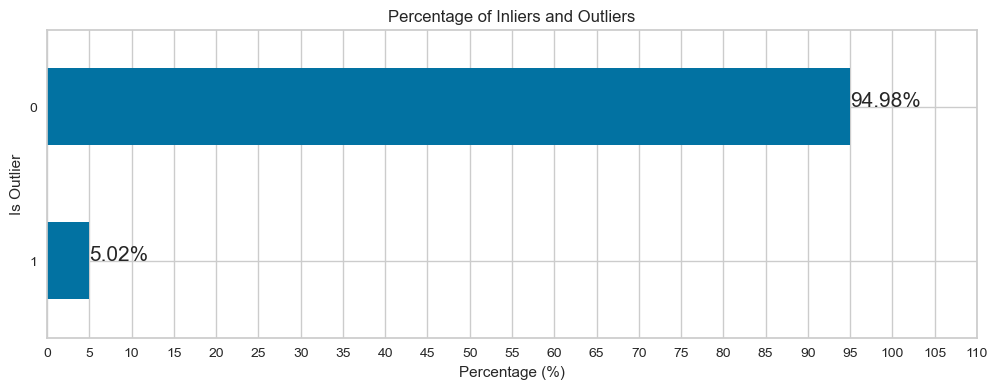

In [50]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [51]:
customer_data.head()

,CustomerID,days_since_last_purchase,Total_Transactions,Total_Products_Purchased,total_spend,Average_Transaction_Value,Unique_Product_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1,0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,1,0
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1,0
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1,0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1,0


**Conclusion:**

Considering the nature of our project (customer segmenation/system recommnedation) it is crucial for us to take care of the outliers to prevent them from affecting the quality of our cluster significatntly. Therefore we will seperate those outliers for further analysis and remove them from our main dataset to prepare it for the clustering analysis.

we will proceed using these steps:
1. Seperate the identified outlier for futher analysis
2. Remove outliers from our main dataset to prevent them
3. Drop the auxilary columns(Outlier_Scores and Is_Outlier) 

In [52]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

# 5: Correlation Analysis

It is crucial for us to check whether there are multicollinearity in our dataset (features are highly correlated). multicolliniearlity can affect our model by not allowing our model to learn the actual underlying patterns in the data, as the features does not provide unique information. This could lead our data not well seperated and meaningful.

If we identify multicollinearity, we can utilize dimensionality reduction techniques like PCA. These techniques help in neutralizing the effect of multicollinearity by transforming the correlated features into a new set of uncorrelated variables, preserving most of the original data's variance. This step not only enhances the quality of clusters formed but also makes the clustering process more computationally efficient.

Text(0.5, 1.0, 'Customer Features Correlation')

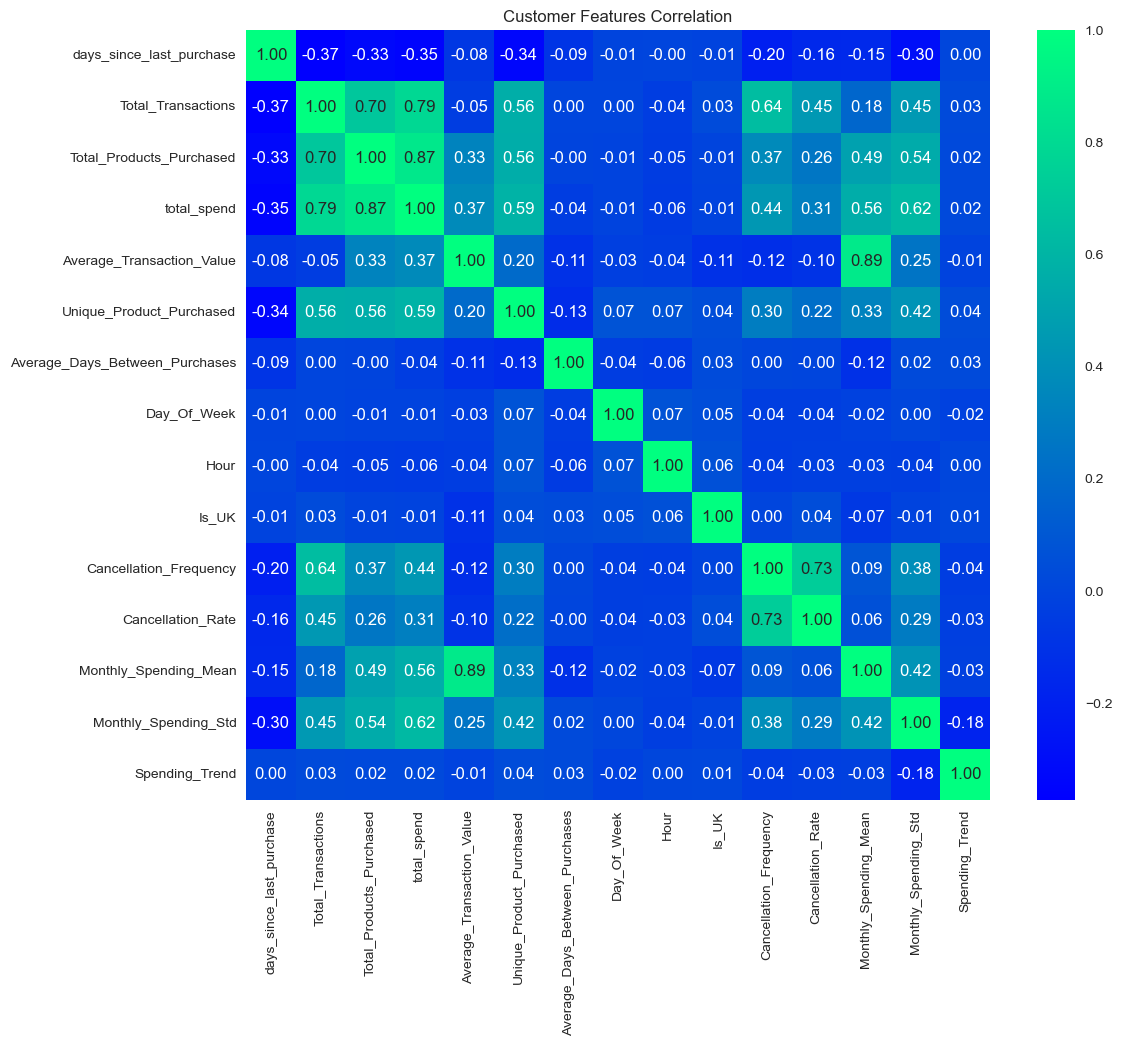

In [53]:
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap='winter', fmt='.2f')
plt.savefig('images/features_correlation_matrix.png')
plt.title('Customer Features Correlation')


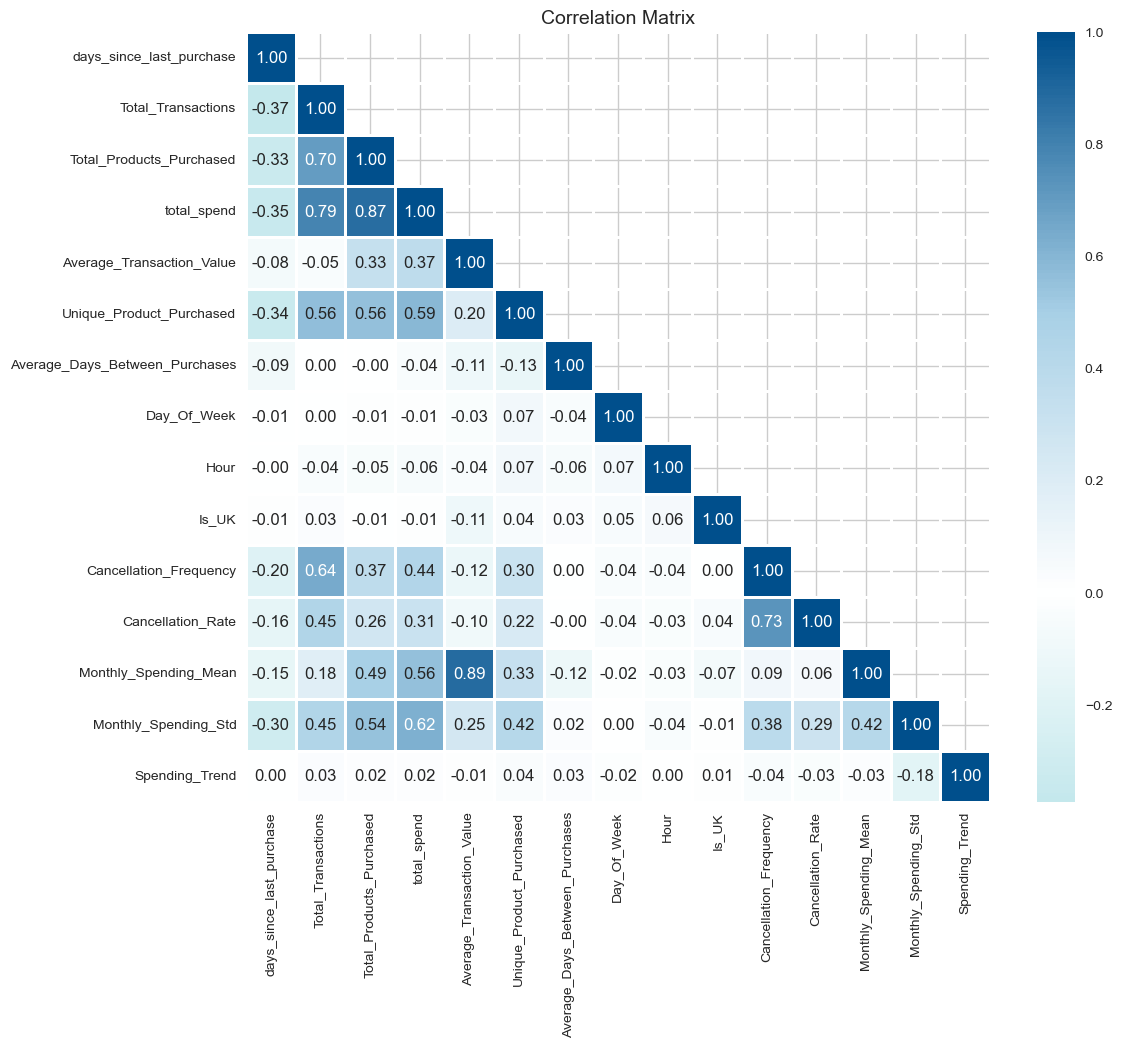

In [54]:
# reset the background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

# Define a custom colormap
colors = ['#00aaff', '#b0e0e6', 'white', '#a8d0e6', '#004f8c']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

Looking at the heatmap, we can see that there are some pairs of variables that have high correlations, for instance:

- `Monthly_Spending_Mean` and `Average_Transaction_Value`
- `Total_Spend` and `Total_Products_Purchased`
- `Total_Transactions` and `Total_Spend`
- `Cancellation_Rate` and `Cancellation_Frequency`
- `Total_Transactions` and `Total_Products_Purchased`

These high correlations indicate that these variables move closely together, implying a degree of multicollinearity.

# 6: Feature Scaling

It's imperative to scale our features. This step holds significant importance, especially in the context of distance-based algorithms like K-means and dimensionality reduction methods like PCA. Here's why:
- For K-means Clustering: K-means relies heavily on the concept of 'distance' between data points to form clusters. When features are not on a similar scale, features with larger values can disproportionately influence the clustering outcome, potentially leading to incorrect groupings.
- For PCA: PCA aims to find the directions where the data varies the most. When features are not scaled, those with larger values might dominate these components, not accurately reflecting the underlying patterns in the data.

**Methodology:**

We are going to standardize our data, meaning transforming the features to have a mean of 0 and a standard deviation of 1. However, not all features require scaling. Here are the exceptions and the reasons why they are excluded:
- `CustomerID`: This feature is just an identifier for the customers and does not contain any meaningful information for clustering.
- `Is_UK`: This is a binary feature indicating whether the customer is from the UK or not. Since it already takes a value of 0 or 1, scaling it won't make any significant difference.
- `Day_Of_Week`: This feature represents the most frequent day of the week that the customer made transactions. Since it's a categorical feature represented by integers (1 to 7), scaling it would not be necessary.

In [55]:
customer_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4067 entries, 0 to 4066
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4067 non-null   string 
 1   days_since_last_purchase        4067 non-null   Int64  
 2   Total_Transactions              4067 non-null   Int64  
 3   Total_Products_Purchased        4067 non-null   Int64  
 4   total_spend                     4067 non-null   Float64
 5   Average_Transaction_Value       4067 non-null   Float64
 6   Unique_Product_Purchased        4067 non-null   Int64  
 7   Average_Days_Between_Purchases  4067 non-null   Float64
 8   Day_Of_Week                     4067 non-null   Int32  
 9   Hour                            4067 non-null   Int32  
 10  Is_UK                           4067 non-null   Int64  
 11  Cancellation_Frequency          4067 non-null   Int64  
 12  Cancellation_Rate               40

In [56]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

# get a list of columns names that are not on the columns_to_exclude list
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,CustomerID,days_since_last_purchase,Total_Transactions,Total_Products_Purchased,total_spend,Average_Transaction_Value,Unique_Product_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,2.345802,-0.477589,-0.754491,-0.813464,-1.317106,-0.908471,-0.310564,1,-1.086929,1,0.420541,0.417623,-1.329018,-0.713318,0.090868
1,12347.0,-0.905575,0.707930,2.005048,2.366920,1.528132,0.815119,-0.128438,1,0.647126,0,-0.545753,-0.432111,0.989511,1.259961,0.116774
2,12348.0,-0.170744,-0.003381,1.863591,0.247087,0.343279,-0.570512,0.672476,3,2.814696,0,-0.545753,-0.432111,0.023997,0.466213,-0.491708
3,12349.0,-0.744516,-0.714692,-0.047205,0.262074,5.418285,0.291283,-0.310564,0,-1.520443,0,-0.545753,-0.432111,4.159521,-0.713318,0.090868
4,12350.0,2.194809,-0.714692,-0.534446,-0.596223,0.043327,-0.655002,-0.310564,2,1.514154,0,-0.545753,-0.432111,-0.220428,-0.713318,0.090868


# 7: Dimensionality Reduction

there are several reason why we need to perform dimensionality reduction including:
- `Multicollinearity Detected`: In the previous steps, we identified that our dataset contains multicollinear features. Dimensionality reduction can help us remove redundant information and alleviate the multicollinearity issue.
- `Better Clustering with K-means`: Since K-means is a distance-based algorithm, having a large number of features can sometimes dilute the meaningful underlying patterns in the data. By reducing the dimensionality, we can help K-means to find more compact and well-separated clusters.
- `Noise Reduction`: By focusing only on the most important features, we can potentially remove noise in the data, leading to more accurate and stable clusters.
- `Enhanced Visualization`: In the context of customer segmentation, being able to visualize customer groups in two or three dimensions can provide intuitive insights. Dimensionality reduction techniques can facilitate this by reducing the data to a few principal components which can be plotted easily.
- `Improved Computational Efficiency`: Reducing the number of features can speed up the computation time during the modeling process, making our clustering algorithm more efficient.
Let's proceed to select an appropriate dimensionality reduction method to our data.

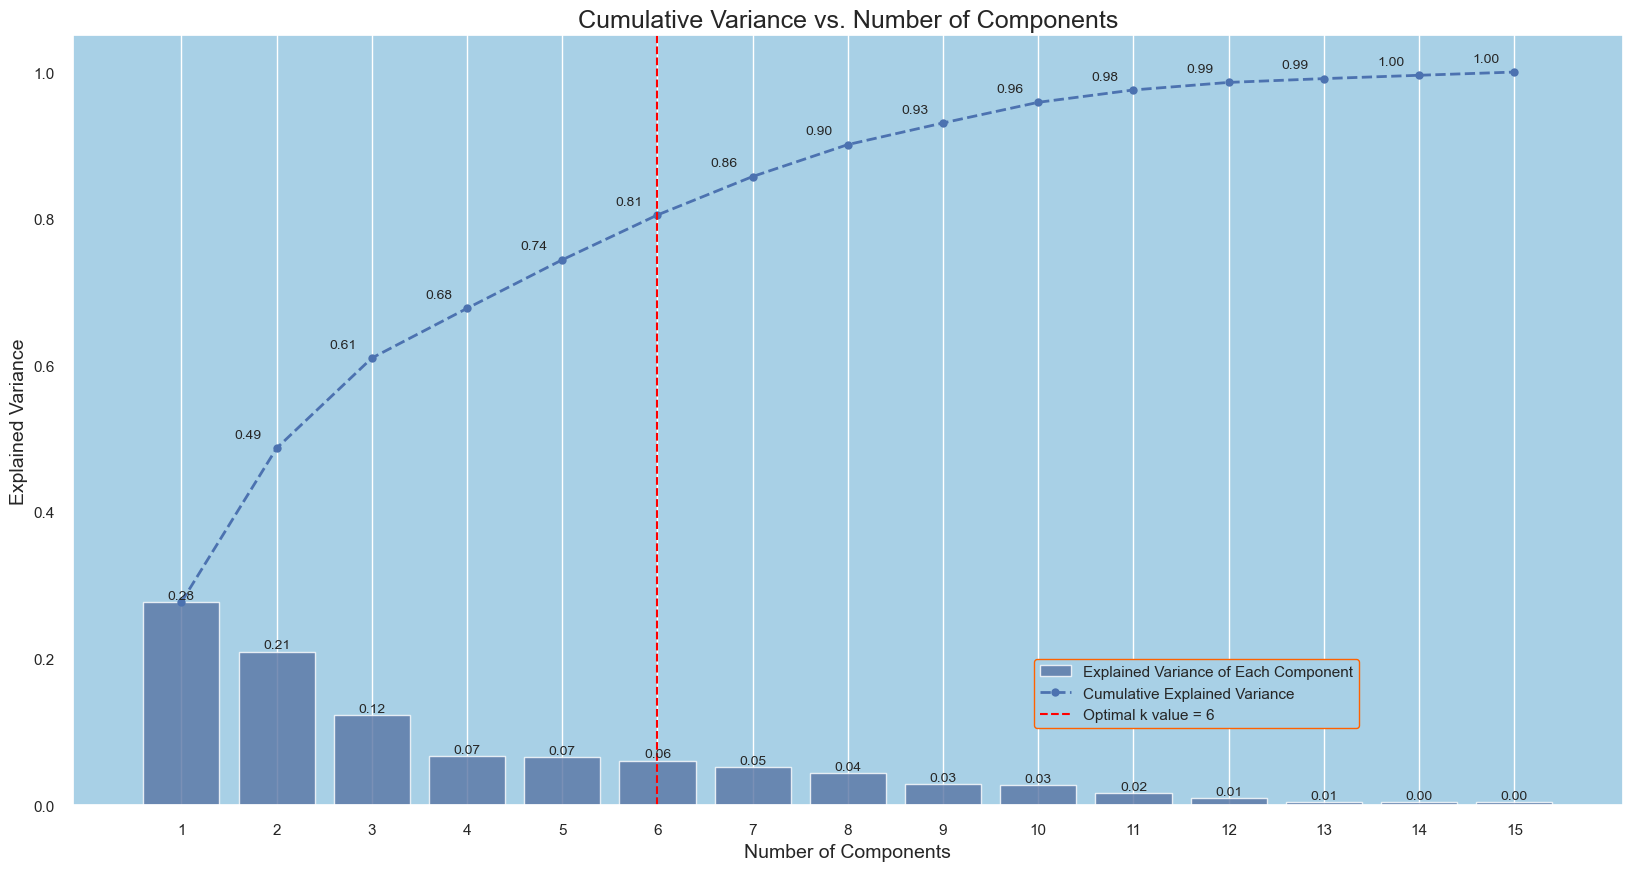

In [57]:
# Setting CustomerID as the index column
customer_data_scaled.set_index('CustomerID', inplace=True)

# Apply PCA
pca = PCA().fit(customer_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
# gives us a list where each value represents the proportion of total variance explained by each principal component.
explained_variance_ratio = pca.explained_variance_ratio_ # how much each feature contribute 
# calulate the cumulative sum 
cumulative_explained_variance = np.cumsum(explained_variance_ratio) # adding up the information

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#a8d0e6'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      # color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200')  

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

**Conclusion:**

The plot and the cumulative explained variance values indicate how much of the total variance in the dataset is captured by each principal component, as well as the cumulative variance explained by the first n components.

Here, we can observe that:

- The first component explains approximately 28% of the variance.

- The first two components together explain about 49% of the variance.

- The first three components explain approximately 61% of the variance, and so on.

To choose the optimal number of components, we generally look for a point where adding another component doesn't significantly increase the cumulative explained variance, often referred to as the "elbow point" in the curve.

From the plot, we can see that the increase in cumulative variance starts to slow down after the 6th component (which captures about 81% of the total variance).

Considering the context of customer segmentation, we want to retain a sufficient amount of information to identify distinct customer groups effectively. Therefore, retaining the first 6 components might be a balanced choice, as they together explain a substantial portion of the total variance while reducing the dimensionality of the dataset.

In [58]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12346.0,-2.186469,-1.705370,-1.576745,1.008187,-0.411803,-1.658012
12347.0,3.290264,-1.387375,1.923310,-0.930990,-0.010591,0.873150
12348.0,0.584684,0.585019,0.664727,-0.655411,-0.470280,2.306657
12349.0,1.791116,-2.695652,5.850040,0.853418,0.677111,-1.520098
12350.0,-1.997139,-0.542639,0.578781,0.183682,-1.484838,0.062672


Now, let's extract the coefficients corresponding to each principal component to better understand the transformation performed by PCA:

In [59]:
# Extract the coefficients corrensponding to each principal component to bettwe understand the transformation performed by pca

def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],  
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
days_since_last_purchase,-0.217859,-0.013986,0.067660,0.273430,-0.240968,-0.373059
Total_Transactions,0.380301,0.014759,-0.259180,-0.138165,-0.017356,-0.028257
Total_Products_Purchased,0.401425,0.007365,0.069133,-0.134806,0.057476,-0.013373
total_spend,0.431260,0.010159,0.065165,-0.092047,0.025202,-0.036947
Average_Transaction_Value,0.176225,-0.015544,0.589050,0.114307,0.021847,-0.101738
Unique_Product_Purchased,0.324992,0.063346,0.014010,-0.230502,-0.193981,0.124604
Average_Days_Between_Purchases,-0.022600,-0.036007,-0.127341,-0.160627,0.753462,0.211787
Day_Of_Week,-0.026572,0.994650,-0.006591,0.028870,0.058359,-0.060799
Hour,-0.024259,0.056388,-0.002019,-0.226832,-0.528881,0.621915
Is_UK,-0.001014,0.007435,-0.018378,-0.013419,-0.005353,0.014384


# 8: K-Means Clustering

## 8.1 Determining The Number of Clusters
To explore the total number of clusters (k) for segmenting customers, we will deploy two methods:
1. Elbow Method
2. Sillhoute Method

## 8.1.1 Elbow Method (code not fully understood)

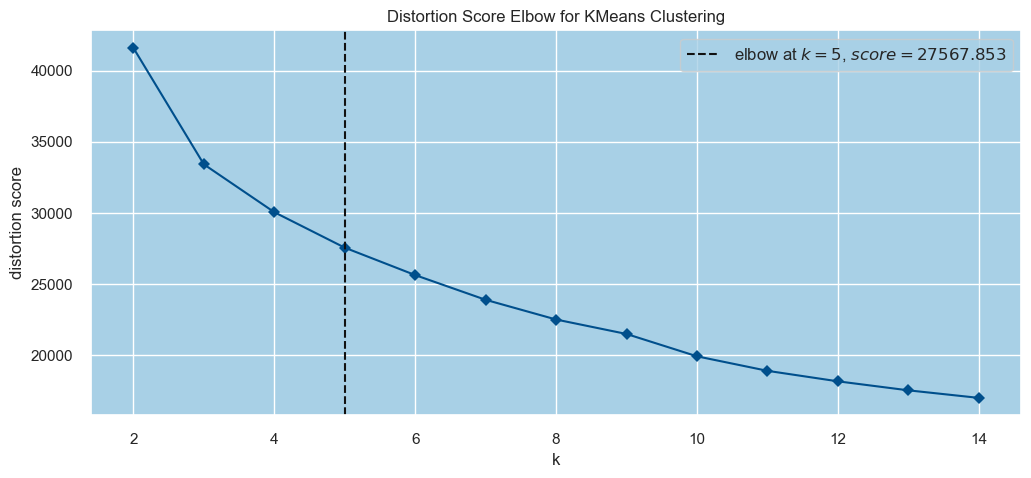

In [60]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#a8d0e6'})

# Set the color palette for the plot
sns.set_palette(['#004f8c'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)
plt.savefig('images/elbow_method_distortion_score.png')
# Finalize and render the figure
visualizer.show();


## 8.1.2 Sillhouette Method (code not fully understood)

The Silhouette Method is an approach to find the optimal number of clusters in a dataset by evaluating the consistency within clusters and their separation from other clusters. It computes the silhouette coefficient for each data point, which measures how similar a point is to its own cluster compared to other clusters.



In [61]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.savefig('images/Sillhouette_score.png')
    plt.show()

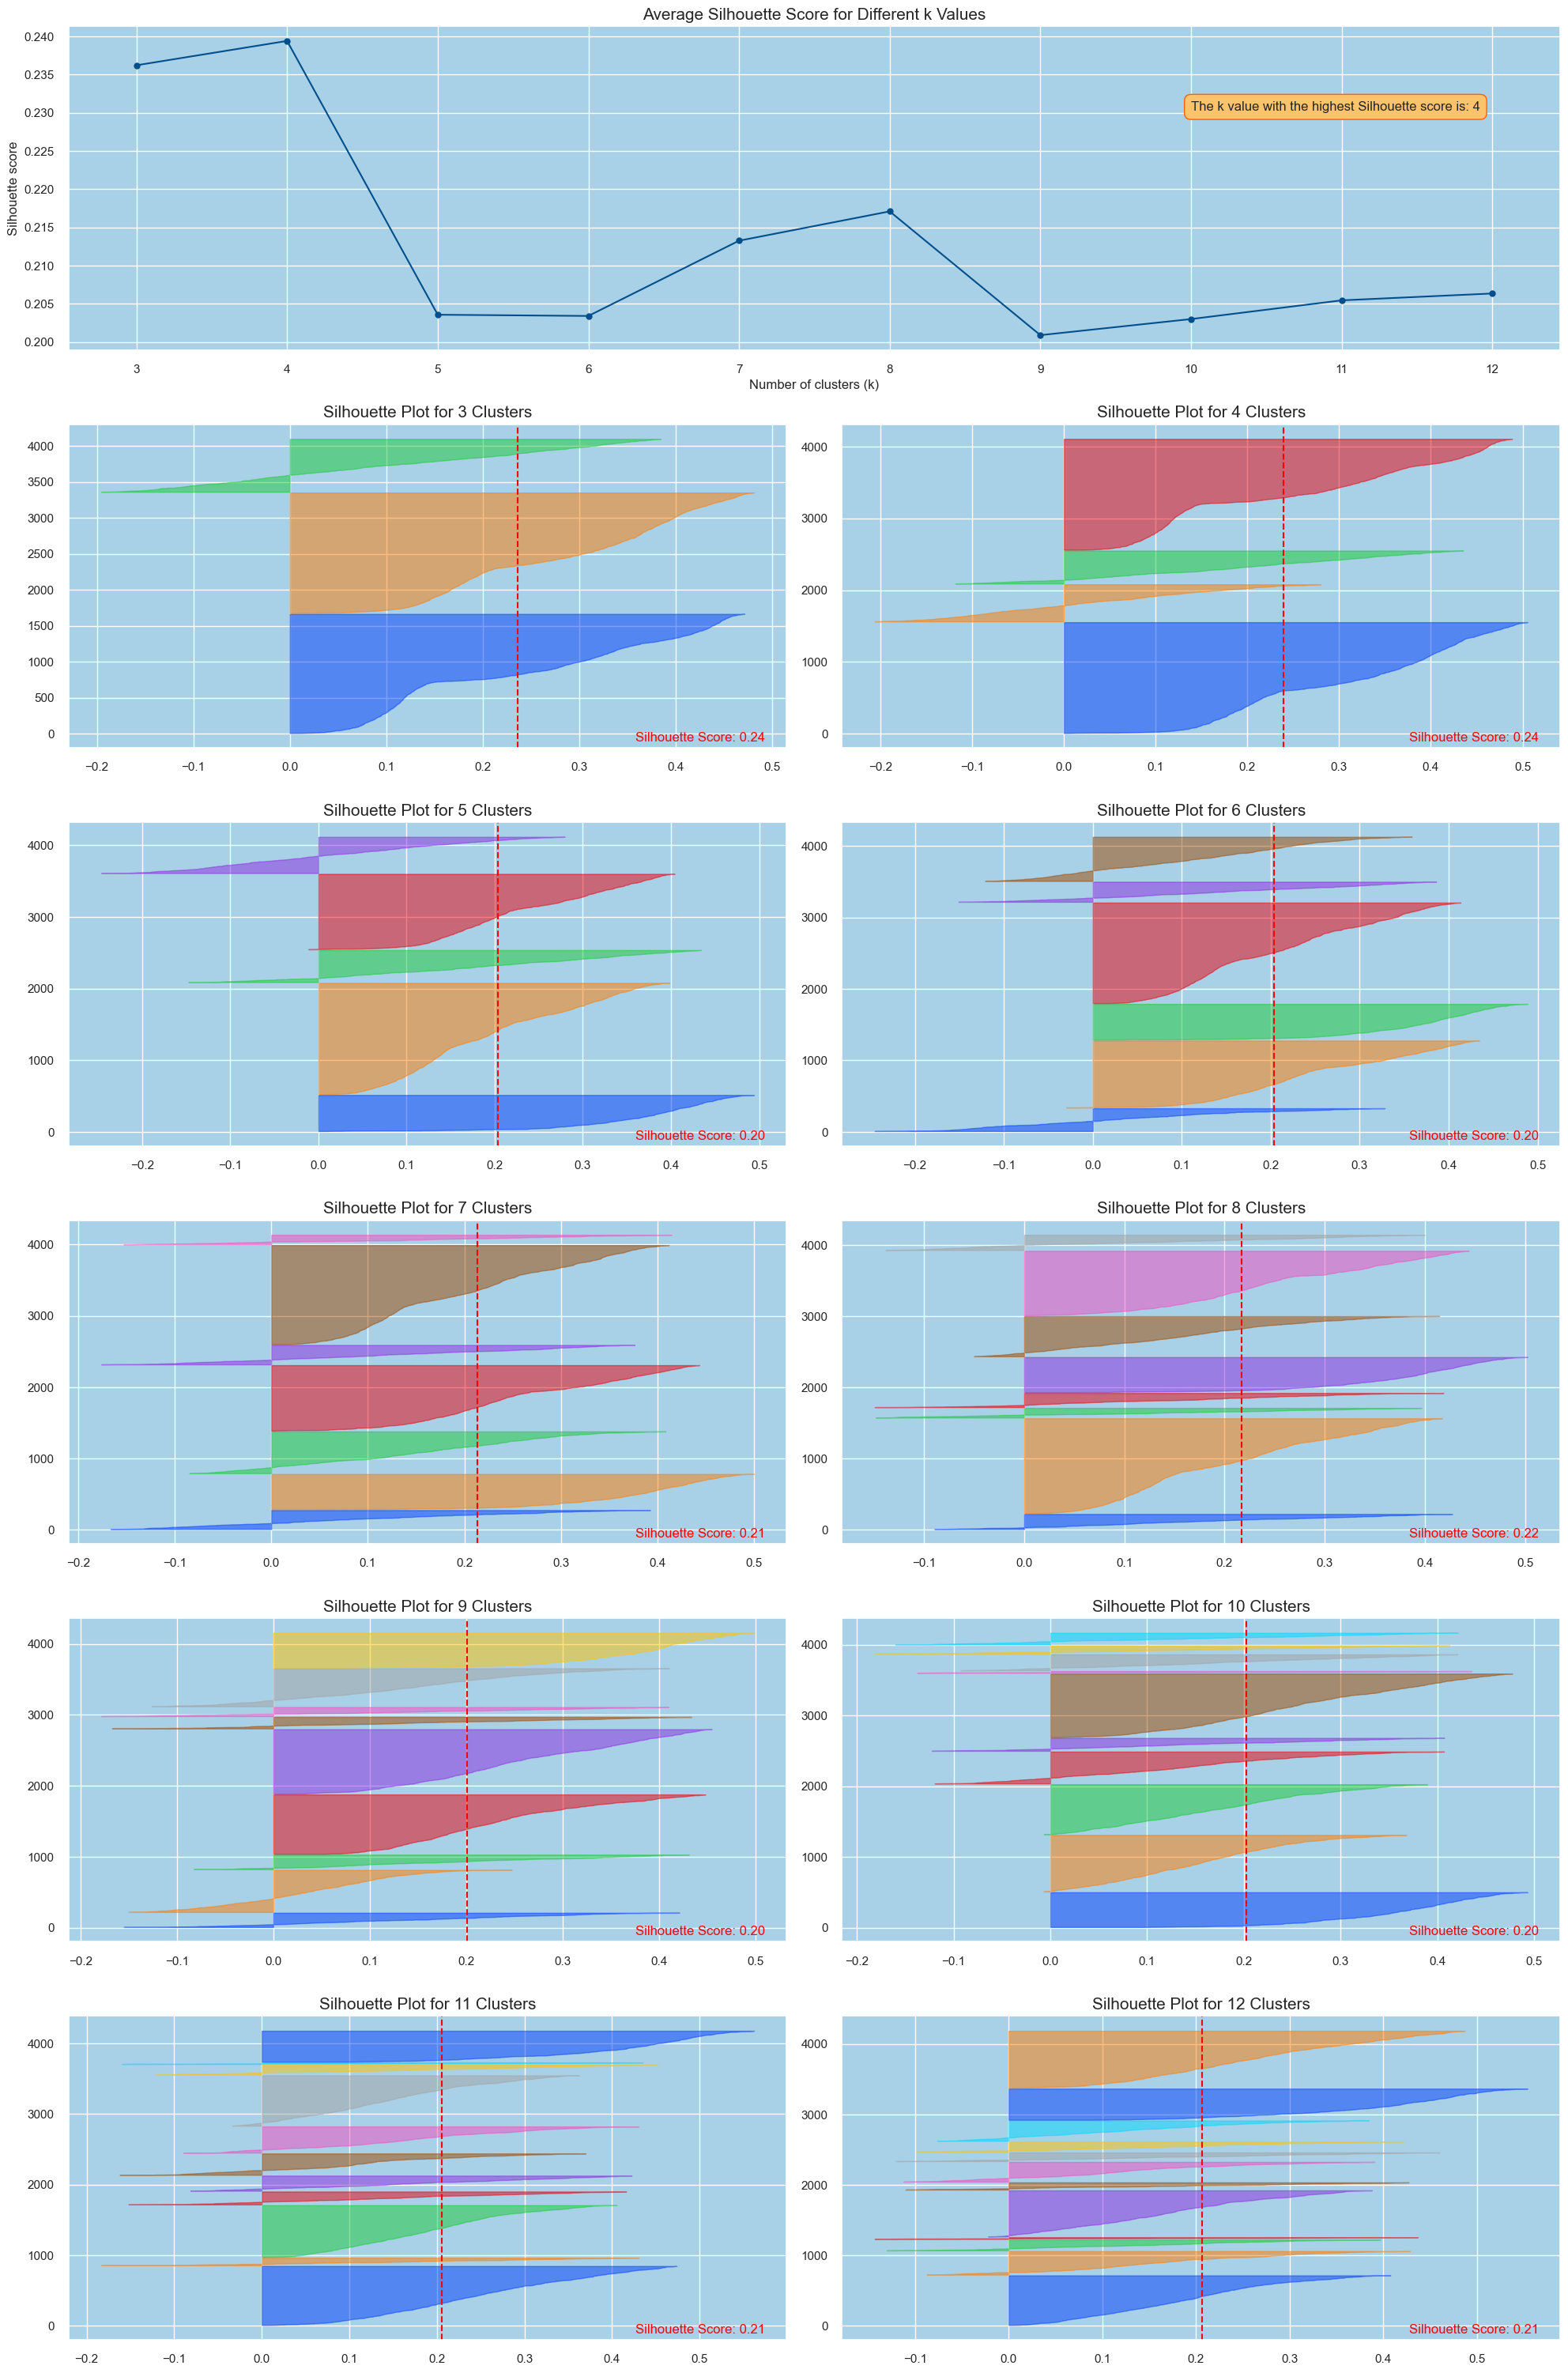

In [ ]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

## Clustering Model: K-Means (not fully understood)

In [63]:
# Fit KMeans with 4 clusters
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# Get frequencies and map most frequent → 0, next → 1, etc.
cluster_frequencies = Counter(kmeans.labels_)
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

# Apply mapping
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Assign new labels
customer_data_cleaned['cluster'] = new_labels
customer_data_pca['cluster'] = new_labels

In [64]:
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,cluster
CustomerID,,,,,,,
12346.0,-2.186469,-1.705370,-1.576745,1.008187,-0.411803,-1.658012,0
12347.0,3.290264,-1.387375,1.923310,-0.930990,-0.010591,0.873150,2
12348.0,0.584684,0.585019,0.664727,-0.655411,-0.470280,2.306657,2
12349.0,1.791116,-2.695652,5.850040,0.853418,0.677111,-1.520098,2
12350.0,-1.997139,-0.542639,0.578781,0.183682,-1.484838,0.062672,0


# 9: Clustering Evaluation
we are going to utilize 3 different types of clustering evaluation: 
1. 3d Visualization of top pcs
2. Cluster Distribution Evaluation
3. Metric Evaluation : Sillhouette Method, Calinzki harabasz score, Davies Bouldin Score


## 9.1 3D visualization of top 4 Principal Components

in this evaluatoin we are going to choose top 4 PCs (which capture the most variability in our data)

In [65]:
# Define colors for 4 clusters (added one more color)
colors = ['#e8000b', '#1ac938', '#023eff', '#ff7f00']  # Red, Green, Blue, Orange

# Create separate DataFrames for each cluster
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]
cluster_3 = customer_data_pca[customer_data_pca['cluster'] == 3]  # New cluster

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster with specified colors
fig.add_trace(go.Scatter3d(
    x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'],
    mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4),
    name='Cluster 0'
))
fig.add_trace(go.Scatter3d(
    x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'],
    mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4),
    name='Cluster 1'
))
fig.add_trace(go.Scatter3d(
    x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'],
    mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4),
    name='Cluster 2'
))
fig.add_trace(go.Scatter3d(
    x=cluster_3['PC1'], y=cluster_3['PC2'], z=cluster_3['PC3'],
    mode='markers', marker=dict(color=colors[3], size=5, opacity=0.4),
    name='Cluster 3'  # New cluster trace
))

# Update layout
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#b0e0e6", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#b0e0e6", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#b0e0e6", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Save the plot (ensure 'images' folder exists)
import os
os.makedirs('images', exist_ok=True)
fig.write_image('images/customer_clusters_in_PCA.png', scale=2)

# Show the plot
fig.show()

## 9.2 Cluster Distribution Evaluation

we are going to utilize bar chart to visualize the percentage of customer in each cluster, which going to help us understand if the cluster are balance and significant


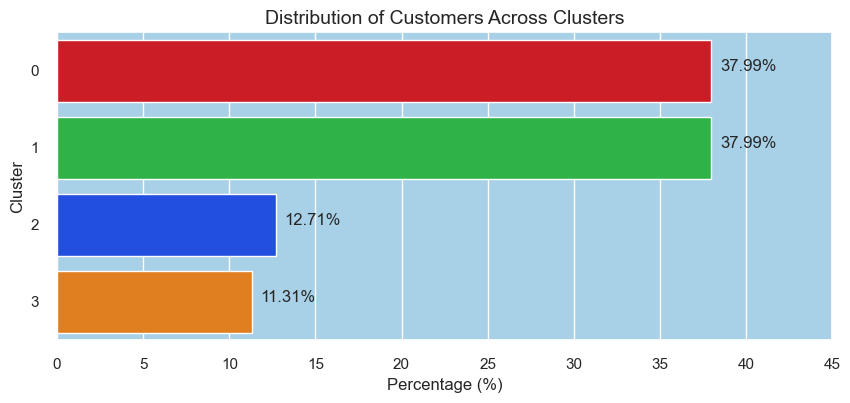

In [66]:
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

plt.savefig('images/cluster_disttribution.png')
plt.show()

The distribution of customers across the clusters, as depicted by the bar plot, suggests a fairly balanced distribution with clusters 0 and 1 holding around 41% of customers each and cluster 2 accommodating approximately 18% of the customers.

This balanced distribution indicates that our clustering process has been largely successful in identifying meaningful patterns within the data, rather than merely grouping noise or outliers. It implies that each cluster represents a substantial and distinct segment of the customer base, thereby offering valuable insights for future business strategies.

Moreover, the fact that no cluster contains a very small percentage of customers, assures us that each cluster is significant and not just representing outliers or noise in the data. This setup allows for a more nuanced understanding and analysis of different customer segments, facilitating effective and informed decision-making.

## 9.3 Evaluation Metrics
we are goig to employ 3 different types of metrics:
1. Silhouette Score : a measure to evaluate seperation distance between clusters. Higher values indicate better cluster seperation. It ranges from -1 to 1
2. Calinski Harabasz Score: This score is used to evaluate the dispersion between and within clusters. A higher score indicates better defined clusters.
3. Davies Bouldin Score: It assesses the average similarity between each cluster and its most similar cluster. Lower values indicate better cluster separation. 

In [67]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+--------------------+
|         Metric          |       Value        |
+-------------------------+--------------------+
| Number of Observations  |        4067        |
|    Silhouette Score     | 0.239417055004378  |
| Calinski Harabasz Score | 1083.1489611442007 |
|  Davies Bouldin Score   | 1.4780907956380533 |
+-------------------------+--------------------+


**Clustering Quality Inference**
- The Silhouette Score of approximately 0.236, although not close to 1, still indicates a fair amount of separation between the clusters. It suggests that the clusters are somewhat distinct, but there might be slight overlaps between them. Generally, a score closer to 1 would be ideal, indicating more distinct and well-separated clusters.

- The Calinski Harabasz Score is 1257.17, which is considerably high, indicating that the clusters are well-defined. A higher score in this metric generally signals better cluster definitions, thus implying that our clustering has managed to find substantial structure in the data.

- The Davies Bouldin Score of 1.37 is a reasonable score, indicating a moderate level of similarity between each cluster and its most similar one. A lower score is generally better as it indicates less similarity between clusters, and thus, our score here suggests a decent separation between the clusters.

In conclusion, the metrics suggest that the clustering is of good quality, with clusters being well-defined and fairly separated. However, there might still be room for further optimization to enhance cluster separation and definition, potentially by trying other clustering and dimensionality reduction algorithms.

# 10 : Cluster Analysis and Profiling

## 10.1 Radar Approach
we are going to create a radar charts to visualize the centroid values of each cluster across different features. This can give a quick visual comparison of the profiles of different clusters. To construct the radar charts, we need to compute the centroid for each cluster. This centroid represents the mean value for all features within a specific cluster. Then, we will display the centroids on the radar charts, that will facilitating a clear visualization of the central tendencies of each feature accross the various cluster

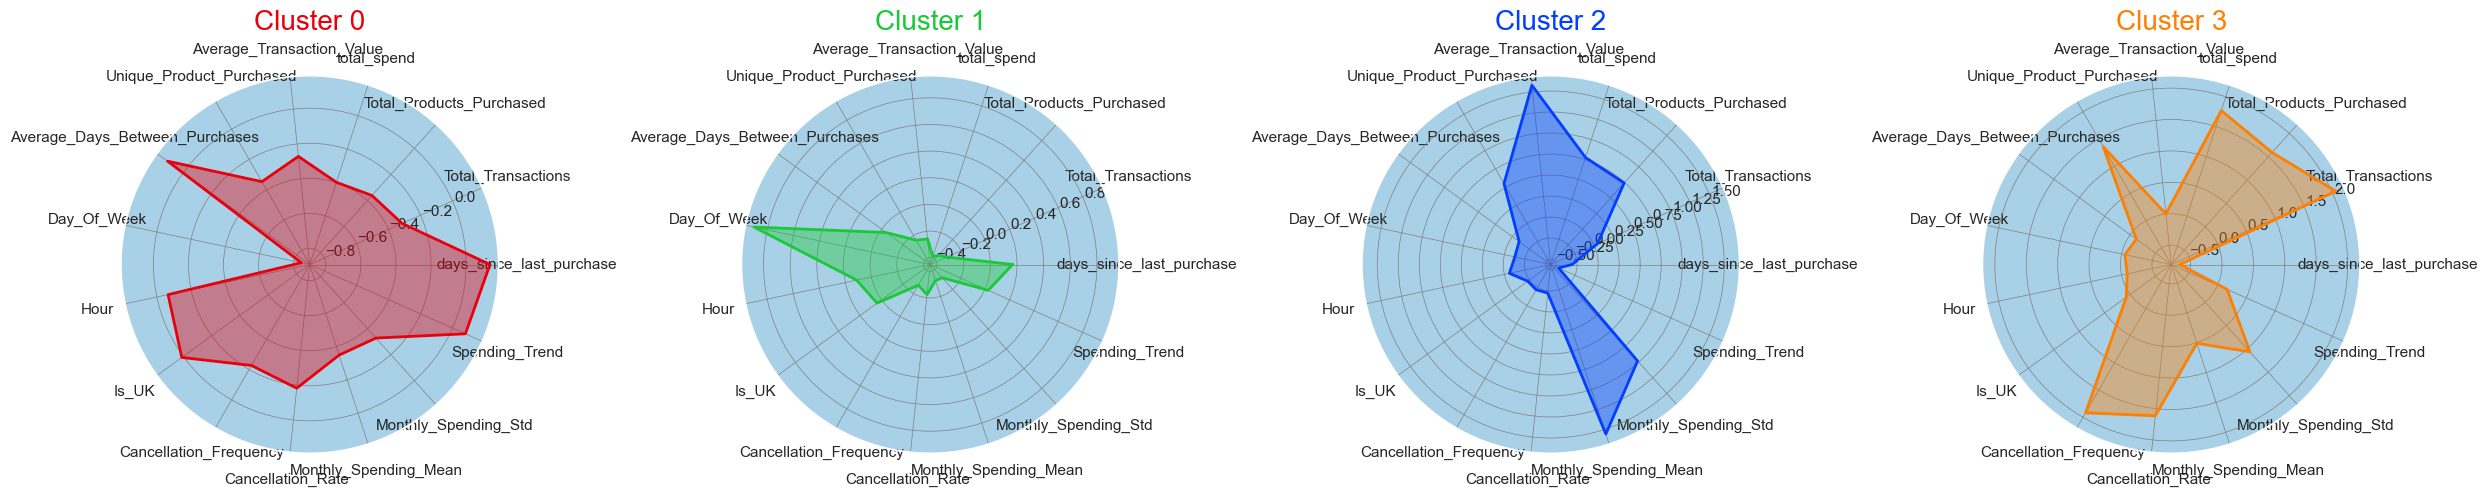

In [68]:
# Setting 'CustomerID' column as index and assigning it to a new dataframe
df_customer = customer_data_cleaned.set_index('CustomerID')

# Standardize the data (excluding the cluster column)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

# Create a new dataframe with standardized values and add the cluster column back
df_customer_standardized = pd.DataFrame(df_customer_standardized, 
                                      columns=df_customer.columns[:-1], 
                                      index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    
    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Initialize the figure (now with 4 subplots)
fig, ax = plt.subplots(figsize=(25, 10),  # Wider figure to accommodate 4 charts
                     subplot_kw=dict(polar=True), 
                     nrows=1, ncols=4)   # Changed to 4 columns

# Update colors to include 4 clusters
colors = ['#e8000b', '#1ac938', '#023eff', '#ff7f00']

# Create radar chart for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

# Configure all axes
for axis in ax:
    axis.set_xticks(angles[:-1])
    axis.set_xticklabels(labels[:-1])
    axis.grid(color='grey', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.savefig('images/radar_chart_of_profiles.png', dpi=300, bbox_inches='tight')
plt.show()

## Customer Profile Derived from Radar Chart Analysis

1. CLUSTER 0 (RED) : Sporadic Shoppers with a preference for weekend shopping
   * With a low number of transaction and product purchase, customer in this cluster tend to spend less
   * With a `Day_Of_Week value`, this means the cluster in this section tends to shopping on the weekend
   * Their spending trend is relatively stable on the lower side and they have a low spending variation indicated by the low `Monthly_Spending_Std`
   * Having a low cancellation frequency and low cancellation rate, meaning they have a low engagement in the cancellation rate
   * The average transaction value on the lower side, 
  
2. CLUSTER 1 (GREEN): Infrequent Big Spenders with High Spending Value 
   * Having a high value on `Average_Days_Between_Purchases` and `days_since_last_purchase` indicating customer in this cluster show a moderate level of spending but their transaction are not very frequent
   * Having a high `spending_trend`, meaning their spending has increased over time
   * The customer in these cluster tend to shop late in the day, as their `hour` value is quite high
   * These customer have a tendency to cancel a moderate number of transactions, with  a high `Cancellation_frequency` and `Cancellation_Rate`
   * These customer have considerably high `Average_transaction_value` meaning when they shop, they tend to make substantional purchase

3. CLUSTER 2 (BLUE) : Frequent High-Spender with a High Cancellation Rate
   * Customer in this cluster are a high spender and they purchased a wide variety of producst, with a high value of `total_spend` and `Unique_produc_purchased`
   * Having a high `Cancellation_rate` and `total_products_purchased` meaning they have a frequent cancellation and frequent transactions
   * These customer has a very low average spending average time between purchase, and with a low `Hour` value, suggesting they tend to shop early in the day.
   * Their monthly spending shows high variability, indicating that their spending patterns might be less predictable compared to other clusters.
   * Despite their high spending, they show a low spending trend, suggesting that their high spending levels might be decreasing over time.

## 10.2 Histogram Chart Approach

In order to validate the radar chart, we can plot each feature segmented by the cluster labels. These histograms will allow us to visually inspect the distribution of feature values within each cluster, thereby confirming or refining the profiles we have created based on the radar charts.


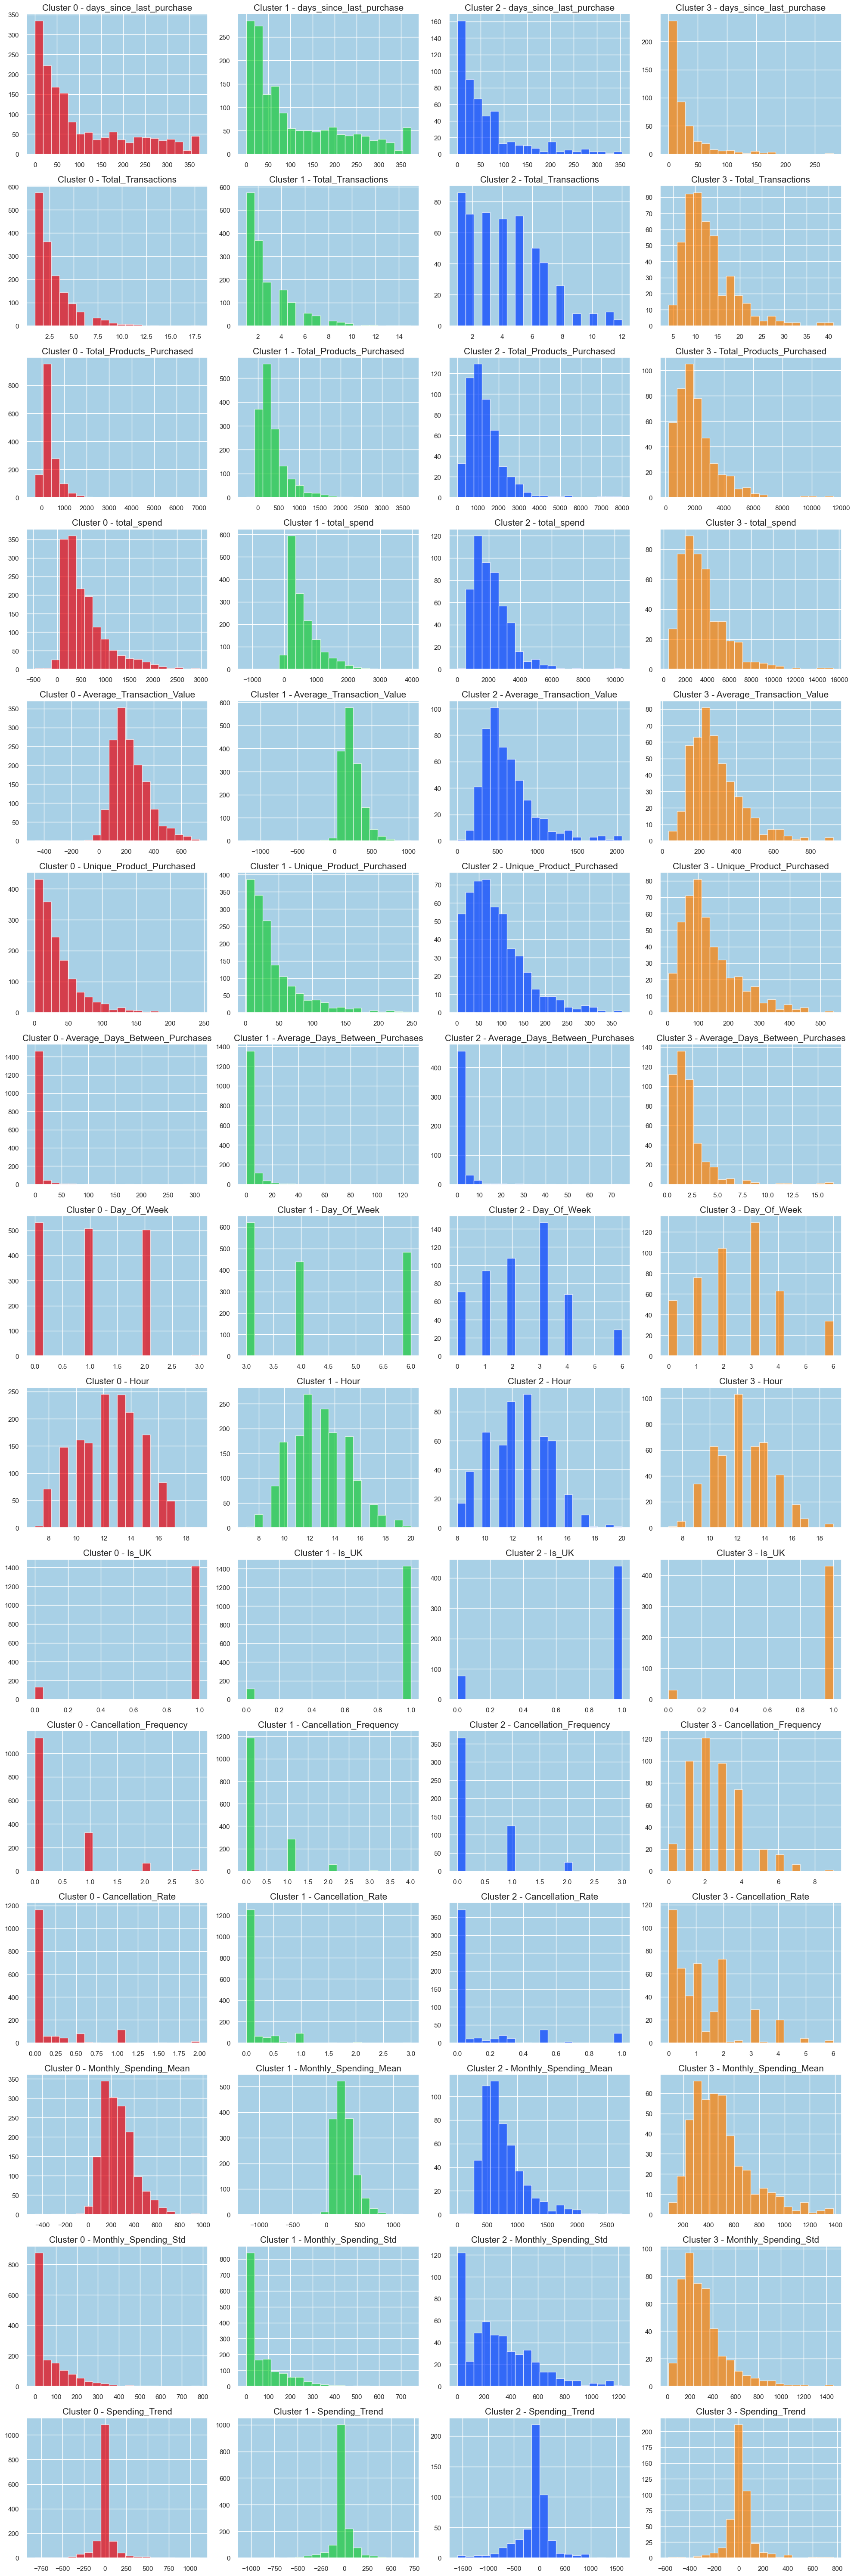

In [69]:
# plot histogrma for each feature segmented by the clusters
features = customer_data_cleaned.columns[1:-1]
clusters = customer_data_cleaned['cluster'].unique()

clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

# 11: Recommendation System 

This recommendation system will suggest product to customer based on the purchasing patterns prevalent in their respective cluster.  as from the earlier part of this project, during the customer data preparation, we isolate the a small fraction (5%) of the customer outliers identified as outliers and reserved them in the seperate dataset called, `outliers_data` 

Now, focusing on the core 95% of the customer group, I analyze the cleansed customer data to pinpoint the top-selling products within each cluster. Leveraging this information, the system will craft personalized recommendations, suggesting the top three products popular within their cluster that they have not yet purchased. This not only facilitates targeted marketing strategies but also enriches the personal shopping experience, potentially boosting sales. For the outlier group, a basic approach could be to recommend random products, as a starting point to engage them.

In [70]:
outliers_data.head()

,CustomerID,days_since_last_purchase,Total_Transactions,Total_Products_Purchased,total_spend,Average_Transaction_Value,Unique_Product_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
9,12356.0,22,3,1573,2487.43,829.143333,52,5.315789,1,9,0,0,0.0,829.143333,991.462585,-944.635,-1,1
10,12357.0,33,1,2708,6207.67,6207.67,131,0.0,6,16,0,0,0.0,6207.67,0.0,0.0,-1,1
12,12359.0,7,6,1599,6182.98,1030.496667,214,1.296,3,12,0,2,0.333333,1030.496667,1137.566659,25.072571,-1,1
26,12377.0,315,2,942,1548.12,774.06,71,0.52,0,9,0,0,0.0,774.06,321.677017,-454.92,-1,1
27,12378.0,129,1,2529,4008.62,4008.62,219,0.0,1,10,0,0,0.0,4008.62,0.0,0.0,-1,1


In [71]:
# Step 1 : Extract the CustomerID of the outliers and remove their transaction from the dataframe
outliers_customer_ids = outliers_data['CustomerID'].astype(float).unique()
df_filtered = df[~df['CustomerID'].isin(outliers_customer_ids)]

# step 2 : Ensure consistent data type for CustomerID across both dataframe before merging
customer_data_cleaned['CustomerID'] = customer_data_cleaned['CustomerID'].astype(float)

# step 3 : merge the transactions data with the customer data to get the cluster information for each transaction 
merged_data = df_filtered.merge(customer_data_cleaned[['CustomerID', 'cluster']], on='CustomerID', how='inner')

# Step 4: Identify the top 10 best-selling products in each cluster based on the total quantity sold
best_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)

# Step 5: Create a record of products purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

# Step 6: Generate recommendations for each customer in each cluster
recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['CustomerID']
    
    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) & 
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()
        
        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)
        
        # Append the recommendations to the list
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

# Step 7: Create a dataframe from the recommendations list and merge it with the original customer data
recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
customer_data_with_recommendations = customer_data_cleaned.merge(recommendations_df, on=['CustomerID', 'cluster'], how='right')

In [72]:
customer_data_with_recommendations.set_index('CustomerID').iloc[:, -6:].sample(10, random_state=0)

,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description
CustomerID,,,,,,
16212.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER
16205.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER
18268.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER
18218.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER
15850.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER
14622.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER
14040.0,22616,PACK OF 12 LONDON TISSUES,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT
18015.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER
17659.0,22616,PACK OF 12 LONDON TISSUES,84879,ASSORTED COLOUR BIRD ORNAMENT,84946,ANTIQUE SILVER T-LIGHT GLASS
